Loading and engineering features...
Building the High-Accuracy MLP model...
Training the model (this will take a moment)...

Evaluating model on test data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

=== FINAL MLP PERFORMANCE METRICS ===
Mean Absolute Error (MAE): 1.4498 rings
Root Mean Squared Error (RMSE): 2.1293 rings
R^2 Score: 0.5812
Tolerance Accuracy (+/- 1 Ring): 67.70%


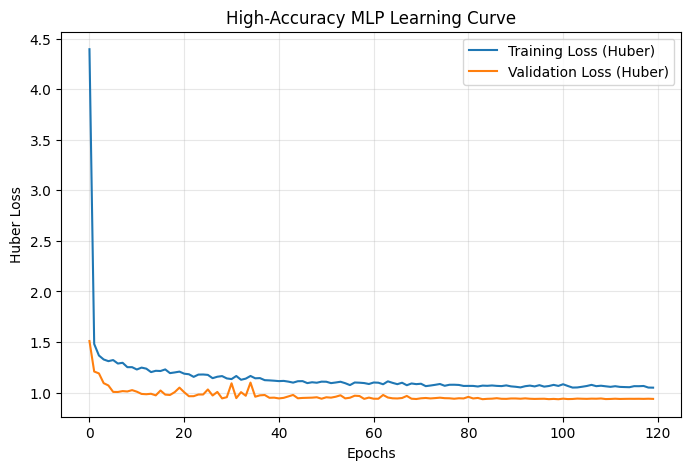

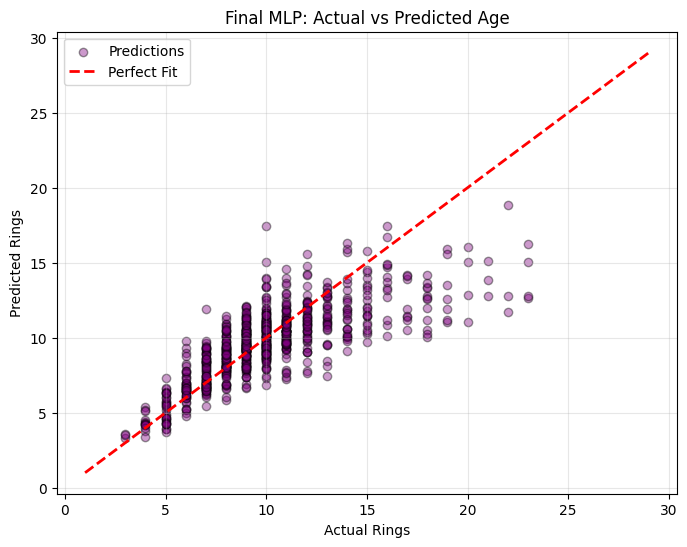


=== CASE STUDY: 5 RANDOM TEST SAMPLES ===
Sample   | Actual   | Predicted  | Error    | Result
------------------------------------------------------------
1        | 7        | 9          | 2        | ❌ MISS
2        | 11       | 11         | 0        | ✅ GOOD
3        | 10       | 9          | 1        | ✅ GOOD
4        | 11       | 10         | 1        | ✅ GOOD
5        | 8        | 8          | 0        | ✅ GOOD


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score

# ==========================================
# 1. DATA PREPARATION & FEATURE ENGINEERING
# ==========================================
print("Loading and engineering features...")
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
                'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']

# Load the dataset
df = pd.read_csv('abalone.data', names=column_names)

# FEATURE ENGINEERING
# Create Volume (L * W * H)
df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
# Create Density (Weight / Volume). Added 1e-5 to prevent dividing by zero.
df['Density'] = df['Whole_weight'] / (df['Volume'] + 1e-5)

# Drop Length to reduce multicollinearity (since it's 99% correlated with Diameter)
df = df.drop('Length', axis=1)

# One-hot encode the 'Sex' column
df = pd.get_dummies(df, columns=['Sex'], prefix='Sex')

# Separate features (X) and target (y)
X = df.drop('Rings', axis=1)
y = df['Rings']

# Split into 80% Training and 20% Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 2. HIGH-ACCURACY MODEL DEFINITION
# ==========================================
print("Building the High-Accuracy MLP model...")
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),

    # Layer 1
    Dense(128, activation='relu', name='Hidden_Layer_1'),
    Dropout(0.2, name='Dropout_1'),

    # Layer 2
    Dense(64, activation='relu', name='Hidden_Layer_2'),
    Dropout(0.1, name='Dropout_2'),

    # Layer 3
    Dense(32, activation='relu', name='Hidden_Layer_3'),

    # Output Layer
    Dense(1, activation='linear', name='Output_Layer')
])

# ADVANCED COMPILATION: Huber loss handles outliers much better than MSE
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='huber',
              metrics=['mae'])

# ==========================================
# 3. TRAINING WITH SCHEDULER
# ==========================================
print("Training the model (this will take a moment)...")

# Stop early if validation loss doesn't improve for 20 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Reduce Learning Rate by half if validation loss stalls for 10 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-5,
    verbose=0
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=250,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

# ==========================================
# 4. EVALUATION & METRICS
# ==========================================
print("\nEvaluating model on test data...")
y_pred = model.predict(X_test_scaled).flatten()
y_pred_rounded = np.round(y_pred)

# Calculate Metrics
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)
tolerance_acc = np.mean(np.abs(y_pred_rounded - y_test) <= 1)

print("\n=== FINAL MLP PERFORMANCE METRICS ===")
print(f"Mean Absolute Error (MAE): {mae:.4f} rings")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f} rings")
print(f"R^2 Score: {r2:.4f}")
print(f"Tolerance Accuracy (+/- 1 Ring): {tolerance_acc*100:.2f}%")

# ==========================================
# 5. VISUALIZATIONS
# ==========================================
# Chart 1: Training Loss Curve (Using Huber loss values)
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss (Huber)')
plt.plot(history.history['val_loss'], label='Validation Loss (Huber)')
plt.title('High-Accuracy MLP Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Huber Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('final_mlp_learning_curve.png')
plt.show()
plt.close()

# Chart 2: Actual vs. Predicted Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, color='purple', edgecolor='k', label='Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Fit')
plt.title('Final MLP: Actual vs Predicted Age')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('final_mlp_scatter_plot.png')
plt.show()
plt.close()

# ==========================================
# 6. CASE STUDY OUTPUT
# ==========================================
print("\n=== CASE STUDY: 5 RANDOM TEST SAMPLES ===")
print(f"{'Sample':<8} | {'Actual':<8} | {'Predicted':<10} | {'Error':<8} | {'Result'}")
print("-" * 60)

np.random.seed(99)
indices = np.random.choice(len(y_test), 5, replace=False)

for i, idx in enumerate(indices):
    actual = y_test.iloc[idx]
    pred = int(y_pred_rounded[idx])
    err = abs(actual - pred)
    status = "✅ GOOD" if err <= 1 else "❌ MISS"
    print(f"{i+1:<8} | {actual:<8} | {pred:<10} | {err:<8} | {status}")

File ‘abalone.data’ already there; not retrieving.

Loading and engineering features...
Building the Classification MLP model...
Training the model (this will take a moment)...

Evaluating model on test data...

=== FINAL CLASSIFICATION METRICS ===
Test Accuracy: 84.57%
Test Loss (Binary Crossentropy): 0.3504

=== EXTRA CLASSIFICATION METRICS ===
Recall (Old=1): 0.5683
F1-score (Old=1): 0.6172
Confusion Matrix:
 [[603  50]
 [ 79 104]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8842    0.9234    0.9034       653
           1     0.6753    0.5683    0.6172       183

    accuracy                         0.8457       836
   macro avg     0.7797    0.7459    0.7603       836
weighted avg     0.8384    0.8457    0.8407       836



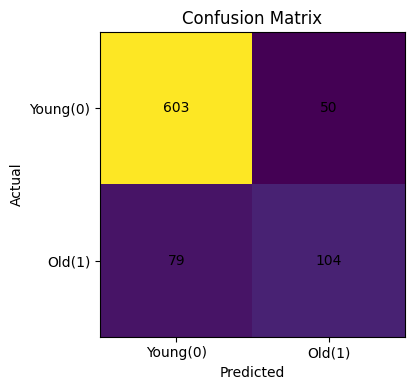


Generating evaluation charts...


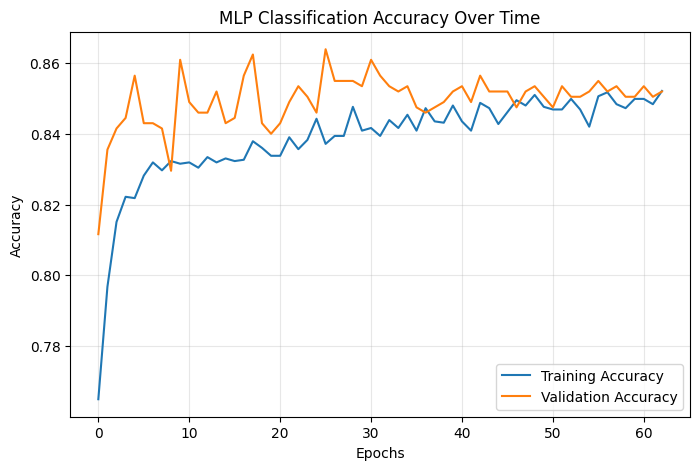

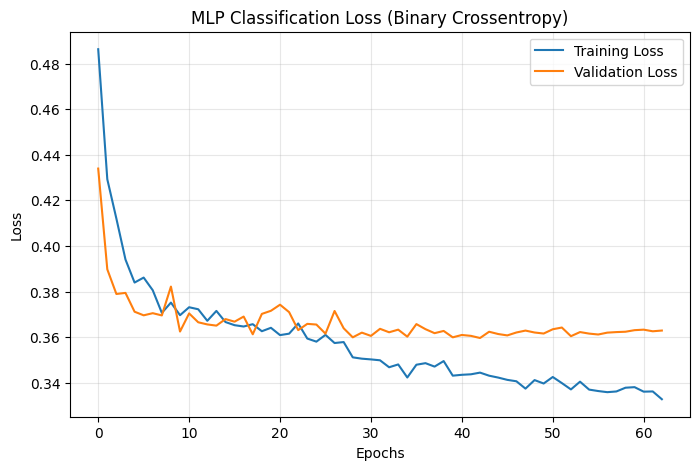

Charts saved as 'mlp_classification_accuracy.png' and 'mlp_classification_loss.png'.

=== CASE STUDY: 5 RANDOM TEST SAMPLES ===
Sample   | Actual Class    | Predicted Prob   | Predicted Class  | Result
--------------------------------------------------------------------------------
1        | Young (<=11)    | 0.0417           | Young (<=11)     | ✅ CORRECT
2        | Young (<=11)    | 0.3828           | Young (<=11)     | ✅ CORRECT
3        | Young (<=11)    | 0.0278           | Young (<=11)     | ✅ CORRECT
4        | Young (<=11)    | 0.0927           | Young (<=11)     | ✅ CORRECT
5        | Young (<=11)    | 0.0393           | Young (<=11)     | ✅ CORRECT


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import recall_score, f1_score, confusion_matrix, classification_report

# Download the dataset if not already present
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data

# ==========================================
# 1. DATA PREPARATION & FEATURE ENGINEERING
# ==========================================
print("Loading and engineering features...")
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
                'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']

df = pd.read_csv('abalone.data', names=column_names)

# FEATURE ENGINEERING
df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
df['Density'] = df['Whole_weight'] / (df['Volume'] + 1e-5)
df = df.drop('Length', axis=1) # Drop highly correlated feature

# THE PIVOT TO CLASSIFICATION (From data_preprocessing.py)
# 1 = Old (Rings > 11), 0 = Young (Rings <= 11)
df["Is_Old"] = np.where(df["Rings"] > 11, 1, 0)
df = df.drop(columns=["Rings"]) # Drop the original continuous target

# One-hot encode the 'Sex' column
df = pd.get_dummies(df, columns=['Sex'], prefix='Sex')

# Separate features (X) and target (y)
X = df.drop('Is_Old', axis=1)
y = df['Is_Old']

# Split into 80% Training and 20% Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 2. CLASSIFICATION MODEL DEFINITION
# ==========================================
print("Building the Classification MLP model...")
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),

    Dense(128, activation='relu', name='Hidden_Layer_1'),
    Dropout(0.2, name='Dropout_1'),

    Dense(64, activation='relu', name='Hidden_Layer_2'),
    Dropout(0.1, name='Dropout_2'),

    Dense(32, activation='relu', name='Hidden_Layer_3'),

    # CHANGED: 'sigmoid' activation is required for binary classification (outputs 0 to 1)
    Dense(1, activation='sigmoid', name='Output_Layer')
])

# CHANGED: Use 'binary_crossentropy' for classification loss and track 'accuracy'
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ==========================================
# 3. TRAINING WITH SCHEDULER
# ==========================================
print("Training the model (this will take a moment)...")

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

# ==========================================
# 4. EVALUATION & METRICS
# ==========================================
print("\nEvaluating model on test data...")

# Evaluate returns loss and accuracy based on our compiled metrics
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

print("\n=== FINAL CLASSIFICATION METRICS ===")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss (Binary Crossentropy): {test_loss:.4f}")

# ==========================================
# 5. EXTRA METRICS REQUIRED FOR CLASSIFICATION
# ==========================================
y_pred_probs = model.predict(X_test_scaled, verbose=0).flatten()
y_pred_class = (y_pred_probs >= 0.5).astype(int)

recall = recall_score(y_test, y_pred_class, pos_label=1)  # 1 = Old
f1 = f1_score(y_test, y_pred_class, pos_label=1)
cm = confusion_matrix(y_test, y_pred_class)

print("\n=== EXTRA CLASSIFICATION METRICS ===")
print(f"Recall (Old=1): {recall:.4f}")
print(f"F1-score (Old=1): {f1:.4f}")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_class, digits=4))

# Confusion matrix plot
plt.figure(figsize=(4.5, 4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1], ["Young(0)", "Old(1)"])
plt.yticks([0, 1], ["Young(0)", "Old(1)"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.tight_layout()
plt.show()
plt.close()

# ==========================================
# 6. VISUALIZATIONS
# ==========================================
print("\nGenerating evaluation charts...")

# Chart 1: Accuracy Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Classification Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('mlp_classification_accuracy.png')
plt.show()
plt.close()

# Chart 2: Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MLP Classification Loss (Binary Crossentropy)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('mlp_classification_loss.png')
plt.show()
plt.close()

print("Charts saved as 'mlp_classification_accuracy.png' and 'mlp_classification_loss.png'.")

# ==========================================
# 7. CASE STUDY OUTPUT
# ==========================================
print("\n=== CASE STUDY: 5 RANDOM TEST SAMPLES ===")
print(f"{'Sample':<8} | {'Actual Class':<15} | {'Predicted Prob':<16} | {'Predicted Class':<16} | {'Result'}")
print("-" * 80)

np.random.seed(99)
indices = np.random.choice(len(y_test), 5, replace=False)

def get_label(val):
    return "Old (>11)" if val == 1 else "Young (<=11)"

for i, idx in enumerate(indices):
    actual_class = y_test.iloc[idx]
    pred_prob = y_pred_probs[idx]

    # If probability > 0.5, predict Class 1 (Old), else Class 0 (Young)
    pred_class = 1 if pred_prob > 0.5 else 0

    status = "✅ CORRECT" if actual_class == pred_class else "❌ INCORRECT"

    print(f"{i+1:<8} | {get_label(actual_class):<15} | {pred_prob:.4f}           | {get_label(pred_class):<16} | {status}")